### Data Analysis
#### Table of Content
1. [Data Overview](#1-data-overview)
1. [Impact of mapping on Latency](#2-impact-of-mapping-on-latency)

In [10]:
# directory_path = 'data/task_5'
# directory_path = 'data/task_10'
directory_path = 'data/task_7'

In [11]:
"""
Importing Generated Data  
"""

import os 
import sys
import pickle 

entries = os.listdir(directory_path)
files = sorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

list_of_dict = []
for file_name in files: 
    file_path = os.path.join(directory_path,file_name)
    with open(file_path, 'rb') as file: 
        dict = pickle.load(file)
        list_of_dict.append(dict)
        
print(f"Number of files in \"{directory_path}\": \t{len(files)}")
print(f"Number of files in imported list: \t{len(list_of_dict)}")

Number of files in "data/task_7": 	11
Number of files in imported list: 	11


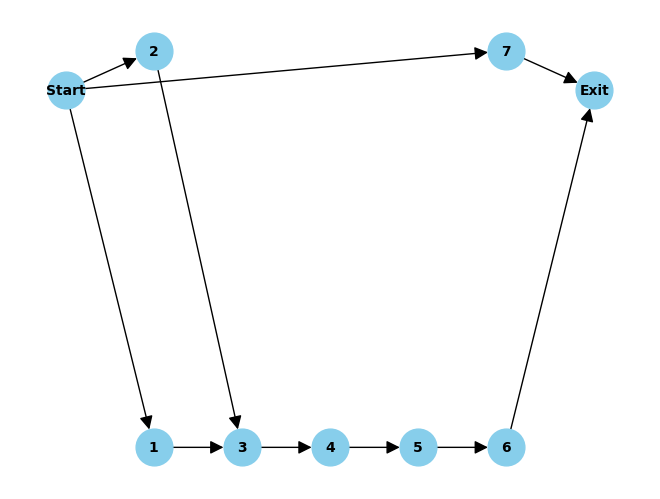

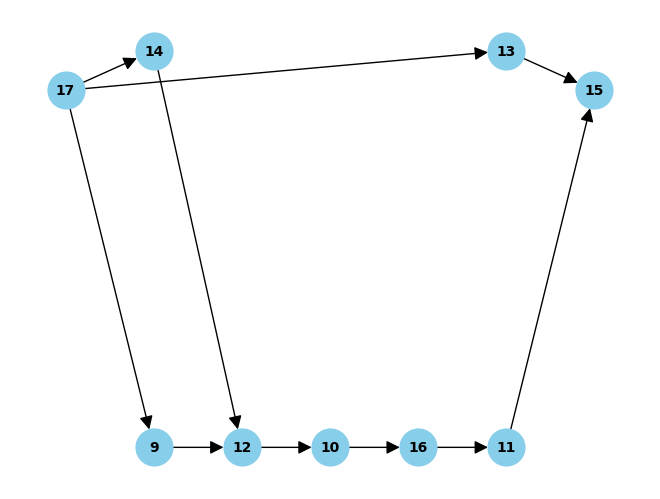

In [12]:
"""
Function for Visualizing Graph Object
"""

import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np

def visGraph(graph, pos=None):
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)
        pos['Start'] = np.array([-1,0])
        pos['Exit'] = np.array([1,0])
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrowsize=20)
    plt.show()

def visGraphGrid(edges):
    nodes = list(range(16,32,1))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    pos = {16: (0, 3), 17: (1, 3), 18: (2, 3), 19: (3, 3),
           20: (0, 2), 21: (1, 2), 22: (2, 2), 23: (3, 2),
           24: (0, 1), 25: (1, 1), 26: (2, 1), 27: (3, 1),
           28: (0, 0), 29: (1, 0), 30: (2, 0), 31: (3, 0)}
    
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrowsize=20)
    plt.title('4x4 Grid Graph')
    plt.show()

task = list_of_dict[0]
if 'task_graph_pos' in task:
    visGraph(task['task_graph'], pos=task['task_graph_pos'])
else: 
    visGraph(task['task_graph'])

visGraph(task['map_graph'], pos=task['map_graph_pos'])
# visGraphGrid(task['map_graph'].edges)

In [13]:
"""
Converting Imported data to Pandas.DataFrame
"""
import pandas as pd 
data_df = pd.DataFrame(list_of_dict)


#### 1. Data overview 

In [14]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("\n\t\t\tProcessing Time Summary")
print(data_df['processing_time'].describe())

print("\n\t\t\tFlit Latency (avg) Summary")
print(data_df['avg_flit_lat'].describe())

print("\n\t\t\tPacket Latency (avg) Summary")
print(data_df['avg_packet_lat'].describe())

print("\n\t\t\tNetwork Latency (avg) Summary")
print(data_df['avg_network_lat'].describe())

pd.set_option('display.float_format', None)


			Processing Time Summary
count      11.000
mean     9924.455
std       168.837
min      9862.000
25%      9870.000
50%      9875.000
75%      9880.000
max     10433.000
Name: processing_time, dtype: float64

			Flit Latency (avg) Summary
count   11.000
mean    13.390
std      1.353
min     10.061
25%     12.932
50%     13.612
75%     14.334
max     14.845
Name: avg_flit_lat, dtype: float64

			Packet Latency (avg) Summary
count   11.000
mean    59.862
std      1.881
min     55.922
25%     59.108
50%     59.941
75%     60.465
max     63.202
Name: avg_packet_lat, dtype: float64

			Network Latency (avg) Summary
count   11.000
mean    59.862
std      1.881
min     55.922
25%     59.108
50%     59.941
75%     60.465
max     63.202
Name: avg_network_lat, dtype: float64


In [15]:
"""
Get Latency Distribution from the number of mapping each task has.
    Given Parameters of the DAG and the demand level, this code will fetch all the mapping and then returns the stats for analysis.
"""

def calculateStats(dataframe, column_names):
    stats_dict = {}
    for column_name in column_names:
        column_range = dataframe[column_name].max() - dataframe[column_name].min()
        column_std_dev = dataframe[column_name].std()
        column_mean = dataframe[column_name].mean()
        column_median = dataframe[column_name].median()
        column_max = dataframe[column_name].max()
        column_min = dataframe[column_name].min()
        
        stats_dict[column_name] = {
            'range': column_range,
            'std': column_std_dev, 
            'mean': column_mean, 
            'median': column_median, 
            'min' : column_min,
            'max' : column_max
        }
    return stats_dict

def plotDualAxis(x, x_label, title, y1, y1_label, y2,  y2_label, log_scale=False):
        fig, ax1 = plt.subplots(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches

        ax1.plot(x, y1, label=y1_label, color='gold')
        if log_scale:
            ax1.set_yscale('log')  # Set log scale for the y-axis on the left
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label )
        ax1.tick_params('y' )

        ax2 = ax1.twinx()

        ax2.plot(x, y2, label=y2_label, color='cadetblue')
        if log_scale:
            ax2.set_yscale('log')  # Set log scale for the y-axis on the left
        ax2.set_ylabel(y2_label)
        ax2.tick_params('y')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.title(title)
        # ax1.grid(True, linestyle='--', alpha=0.7)
        # ax2.grid(True, linestyle='--', alpha=0.7)

        fig.tight_layout()
        plt.show()

def getStatFromFilteredDF(demand_df):
    demand_df.reset_index(inplace=True, drop=True)
    demand_df.index += 1

    stats = calculateStats(demand_df, ['avg_packet_lat', 'avg_flit_lat', 'avg_network_lat', 'processing_time'])
    return stats

def getMapVariation(data_df,max_out, alpha, beta, demand_level=None):
    filtered_df = data_df.query(f"max_out == {max_out} and alpha == {alpha} and beta == {beta} and demand_level == {demand_level}")
    unique_demand = filtered_df['demand'].apply(tuple).unique() # Returns Unique values of Demand

    unique_lists = [list(t) for t in unique_demand] # List of Unique demand values
    
    stat_list = []
    for unique_list in unique_lists:
        demand_df = filtered_df[filtered_df['demand'].apply(lambda x: set(unique_list).issubset(set(x)))] # Filtering dataframe by looking for similar demand
        stat = getStatFromFilteredDF(demand_df)
        stat_list.append(stat)

    return stat_list

max_out_list = sorted(data_df['max_out'].unique())
alpha_list = sorted(data_df['alpha'].unique())
beta_list = sorted(data_df['beta'].unique())
demand_level_list = sorted(data_df['demand_level'].unique())

print(f"Max Out: \t{max_out_list}")
print(f"Alpha: \t\t{alpha_list}")
print(f"Beta: \t\t{beta_list}")
print(f"Demand Level: \t{demand_level_list}")

mapping_data = []
import copy 
for max_out in max_out_list:
    for alpha in alpha_list:
        for beta in beta_list:
            for demand_level in demand_level_list:
                param = {}
                stat_list = getMapVariation(data_df, max_out, alpha, beta, demand_level) # Returns a list with demandCount size [{avg_packet_lat, avg_flit_lat}, {avg_packet_lat, avg_flit_lat}]
                param['max_out'] = max_out
                param['alpha'] = alpha
                param['beta'] = beta
                param['demand_level'] = demand_level

                for demand_stat in stat_list: # Looping through Demand Counts
                    stat = {}
                    for feature_name in demand_stat: # avg_packet_lat or avg_flit_lat
                        for stat_name in demand_stat[feature_name]: # Range, Std, mean, median, min, max
                            name = feature_name + '_' + stat_name
                            stat[name] = demand_stat[feature_name][stat_name]

                    param = {**param, **stat} # Have to use unpacking operator, otherwise (using update) it creates a reference.? 
                    mapping_data.append(param)


print(f"\nLength of mapping Data {len(mapping_data)}")
mapping_data_df = pd.DataFrame(mapping_data)

Max Out: 	[1]
Alpha: 		[0.5]
Beta: 		[0.0]
Demand Level: 	[0]

Length of mapping Data 1


#### 2. Impact of mapping on Latency 

In the data-generation process, each time a task graph is created, we perform multiple random mappings (specifically, 10 different mappings) for the same task. In this section, we explore the impact of these random mappings on packet latency. The presented graph clearly illustrates that latency is influenced by the chosen mapping strategies.

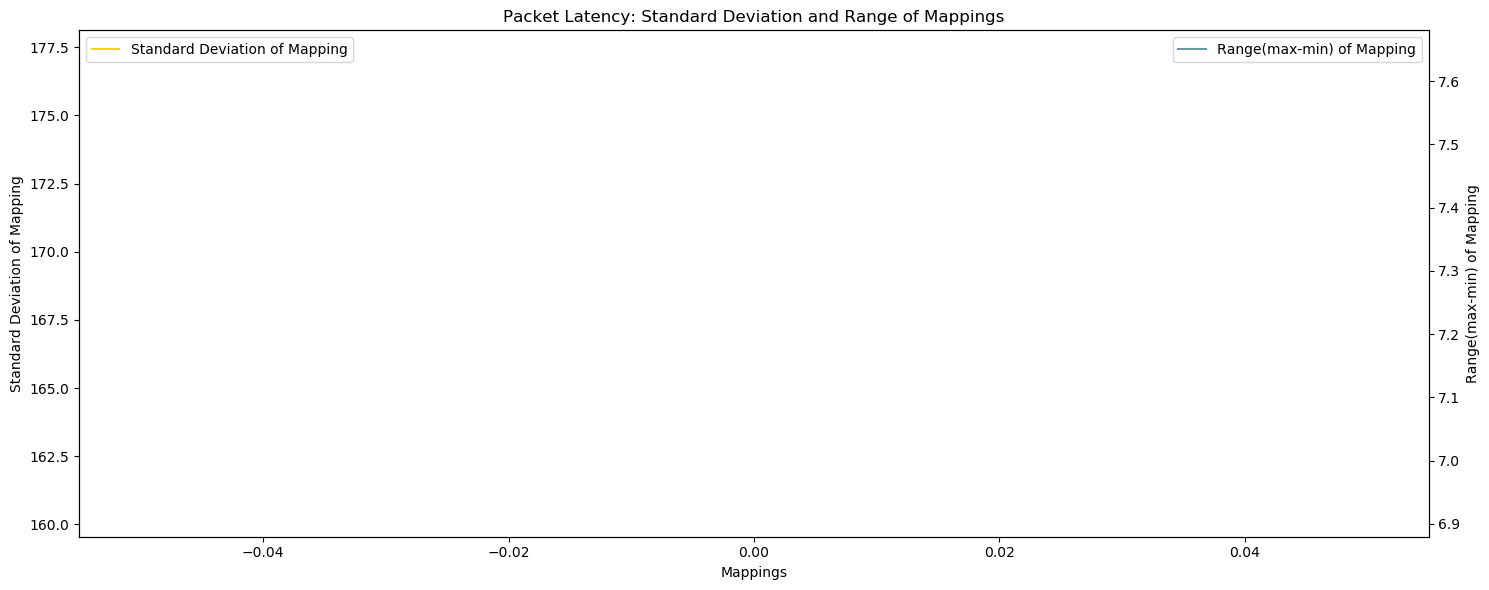

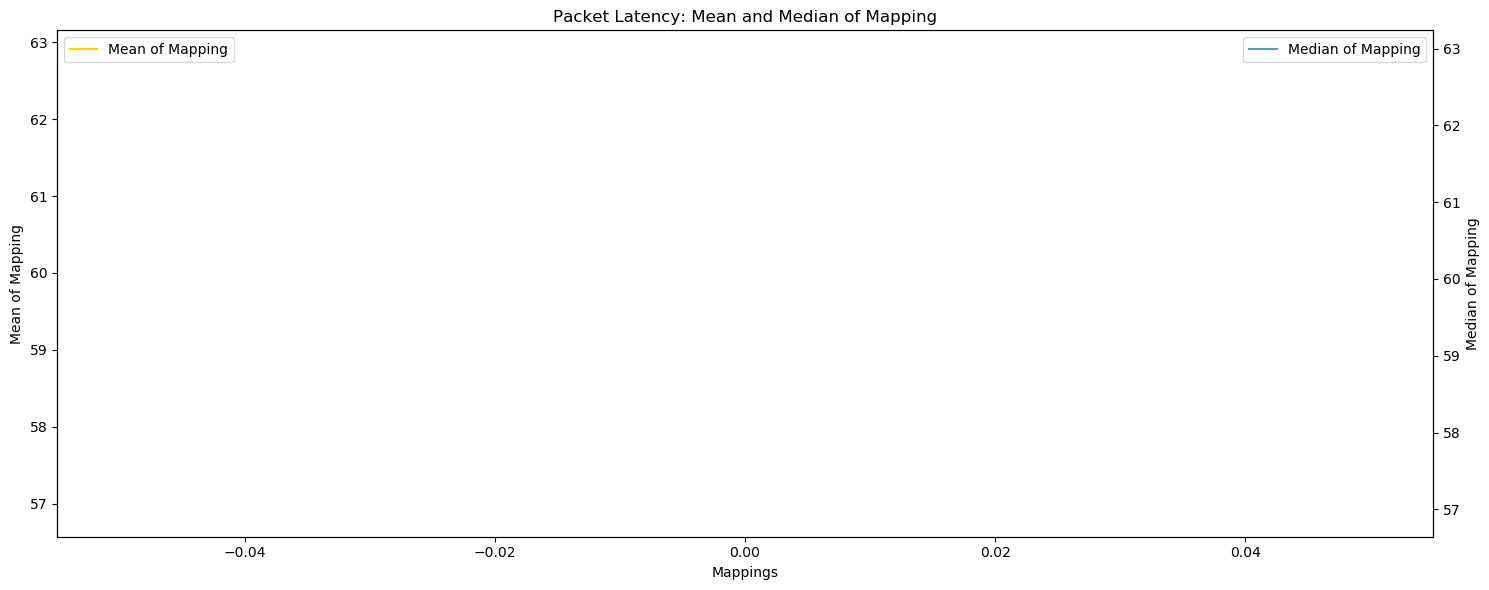

In [16]:
"""
Plot Mapping Data
"""

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Packet Latency: Standard Deviation and Range of Mappings', 
             mapping_data_df['processing_time_std'].to_numpy(), 'Standard Deviation of Mapping', 
             mapping_data_df['processing_time_range'].to_numpy(), 'Range(max-min) of Mapping', )

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Packet Latency: Mean and Median of Mapping', 
             mapping_data_df['avg_packet_lat_mean'].to_numpy(), 'Mean of Mapping', 
             mapping_data_df['avg_packet_lat_median'].to_numpy(), 'Median of Mapping', )

In [8]:
display(mapping_data_df)

,max_out,alpha,beta,demand_level,avg_packet_lat_range,avg_packet_lat_std,avg_packet_lat_mean,avg_packet_lat_median,avg_packet_lat_min,avg_packet_lat_max,...,avg_flit_lat_mean,avg_flit_lat_median,avg_flit_lat_min,avg_flit_lat_max,avg_network_lat_range,avg_network_lat_std,avg_network_lat_mean,avg_network_lat_median,avg_network_lat_min,avg_network_lat_max
0,1,0.5,0.0,0,6.998,2.665043,42.9993,42.9975,39.999,46.997,...,11.1252,11.1240,8.115,15.095,199936.0,6.989822e+04,9.439601e+08,9.439501e+08,9.439001e+08,9.441000e+08
1,1,0.5,0.0,0,22.449,9.075920,49.6803,44.9470,40.833,63.282,...,12.8936,13.0940,8.945,17.612,293200000.0,1.359703e+08,8.095201e+08,7.374001e+08,7.110001e+08,1.004200e+09
2,1,0.5,0.0,0,14.441,6.406162,47.6026,44.7505,40.998,55.439,...,11.6301,11.8850,9.113,13.610,293199936.0,1.513691e+08,1.176150e+09,1.058900e+09,1.058900e+09,1.352100e+09
3,1,0.5,0.0,1,49.355,18.436237,71.4038,63.3630,60.537,109.892,...,18.4133,16.2080,13.365,30.769,249806848.0,9.928692e+07,1.572900e+11,1.572430e+11,1.572430e+11,1.574928e+11
4,1,0.5,0.0,1,22.736,6.461341,59.3094,57.8450,52.763,75.499,...,15.8660,15.7340,10.792,21.054,219906048.0,6.950593e+07,1.499812e+11,1.499592e+11,1.499591e+11,1.501790e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,5,1.5,2.0,0,7.961,2.293484,41.2920,40.9895,38.347,46.308,...,9.4213,9.1190,6.482,14.424,100096.0,4.835096e+04,3.568730e+09,3.568700e+09,3.568700e+09,3.568800e+09
368,5,1.5,2.0,0,12.000,4.289522,42.8000,42.5000,38.000,50.000,...,10.9298,10.6345,6.133,18.133,100096.0,5.275522e+04,3.943750e+09,3.943750e+09,3.943700e+09,3.943800e+09
369,5,1.5,2.0,1,9.000,3.754997,43.1000,42.5000,38.000,47.000,...,11.2249,10.6345,6.133,15.114,98304.0,5.181076e+04,5.195904e+11,5.195904e+11,5.195903e+11,5.195904e+11
370,5,1.5,2.0,1,12.000,3.754997,43.1000,41.0000,38.000,50.000,...,11.2279,9.1290,6.133,18.133,98304.0,5.076397e+04,3.400935e+11,3.400935e+11,3.400935e+11,3.400936e+11


#### 3. Task Shape for same parameters

When same DAG parameters are used to generate a TASK graph, we get slightly different architectures with some degree of similarity. 

Number of elemnts in DataFrame: 30


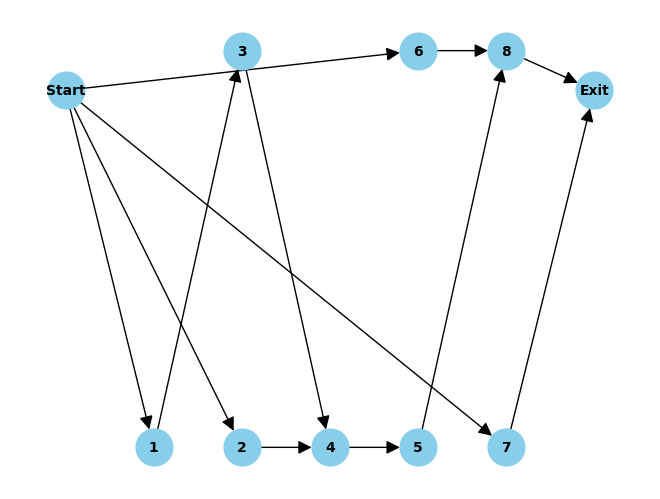

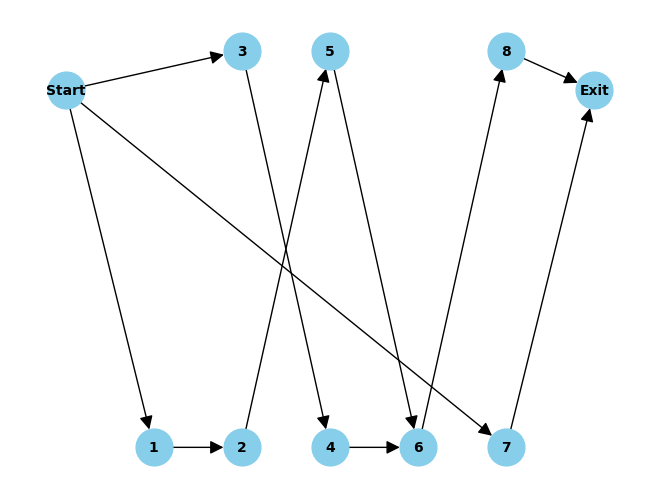

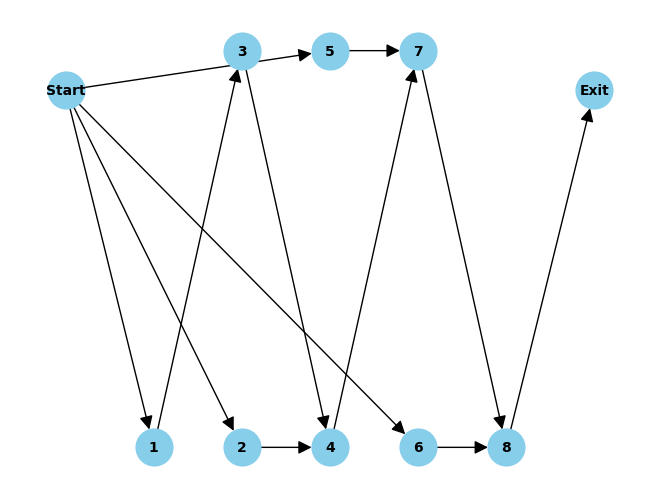

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

filtered_parameter_df = data_df.query(f"max_out == {1} and alpha == {0.5} and beta == {0.0} and demand_level == {0}")
filtered_parameter_df.reset_index(inplace=True, drop=True)

print(f"Number of elemnts in DataFrame: {filtered_parameter_df.count()[0]}")

def displayGraph(index, task=False):

    if task: graph_string = 'task'
    else: graph_string = 'map'

    graph = filtered_parameter_df.loc[index, str(graph_string) + '_graph']
    pos = filtered_parameter_df.loc[index, str(graph_string) + '_graph_pos']
    visGraph(graph, pos=pos)

displayGraph(2, True)
displayGraph(12, True)
displayGraph(22, True)


#### 4. For a given task DAG. 
Mapping is completely different for the same task.

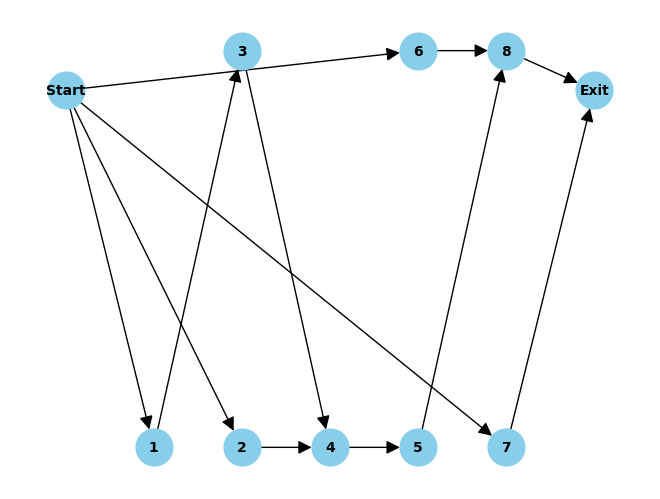

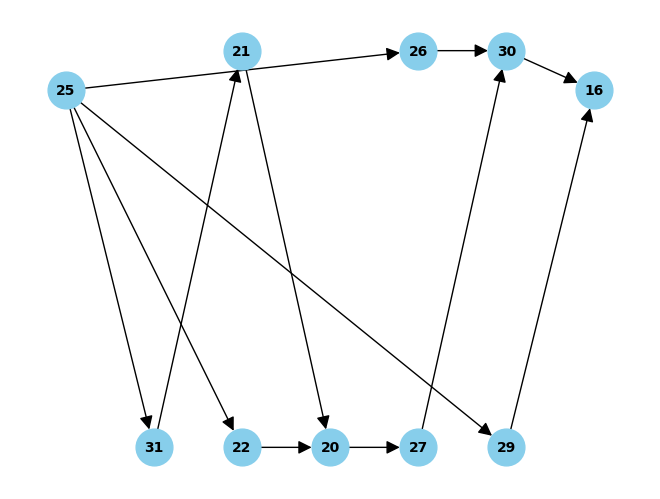

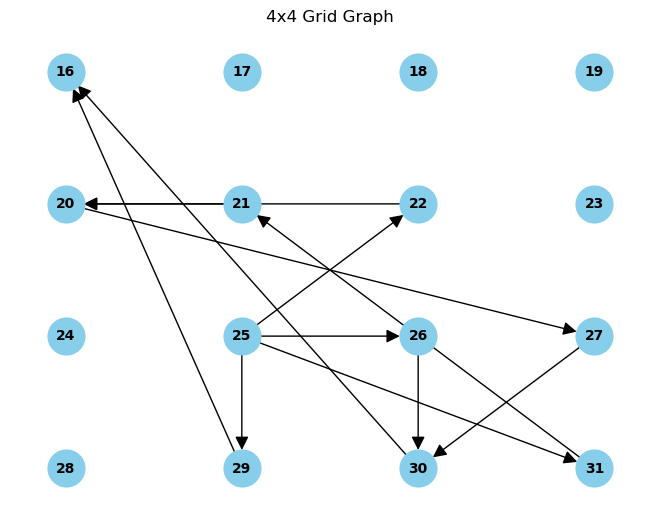

In [11]:
index = 4
displayGraph(index,task=True)
displayGraph(index)
graph = filtered_parameter_df.loc[index, 'map_graph']
visGraphGrid(graph.edges)

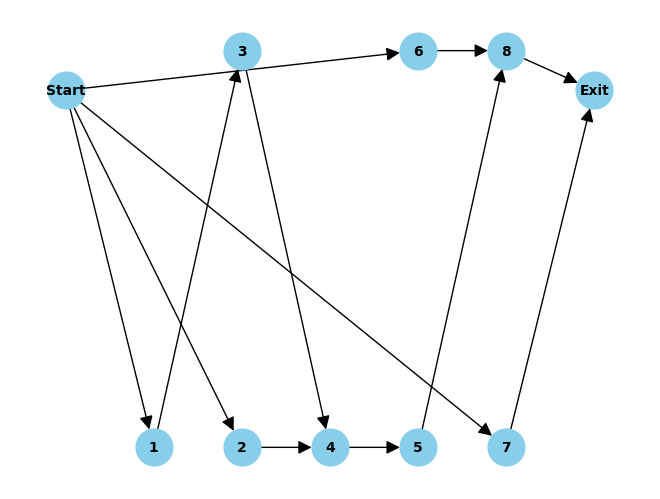

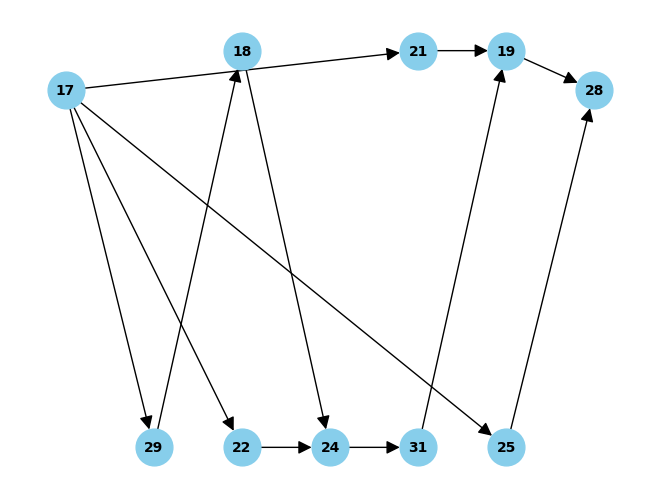

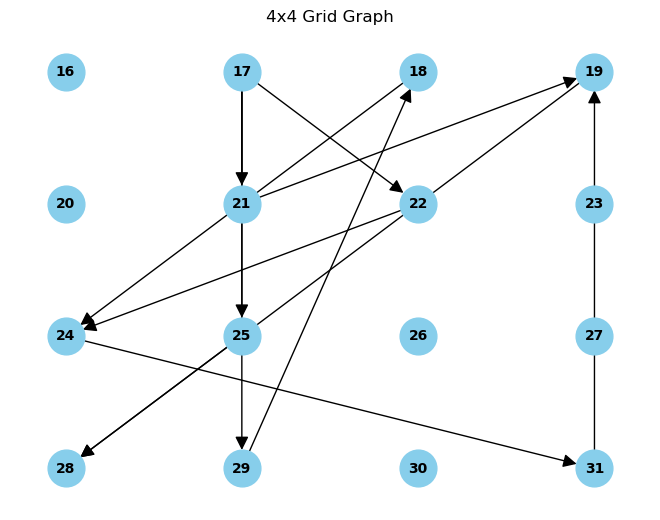

In [12]:
index = 5
displayGraph(index,task=True)
displayGraph(index)
graph = filtered_parameter_df.loc[index, 'map_graph']
visGraphGrid(graph.edges)

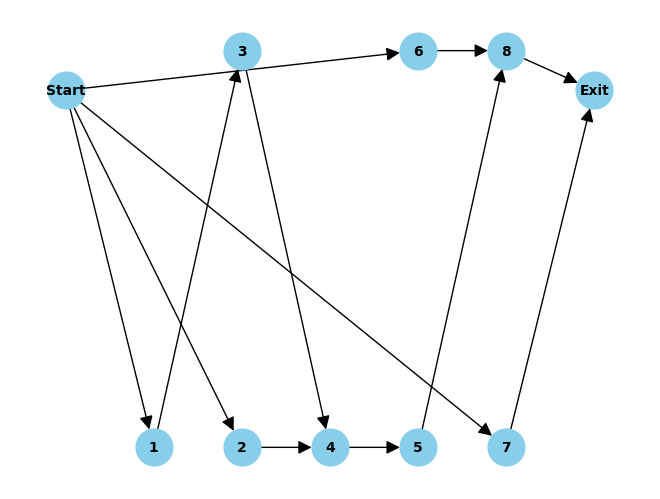

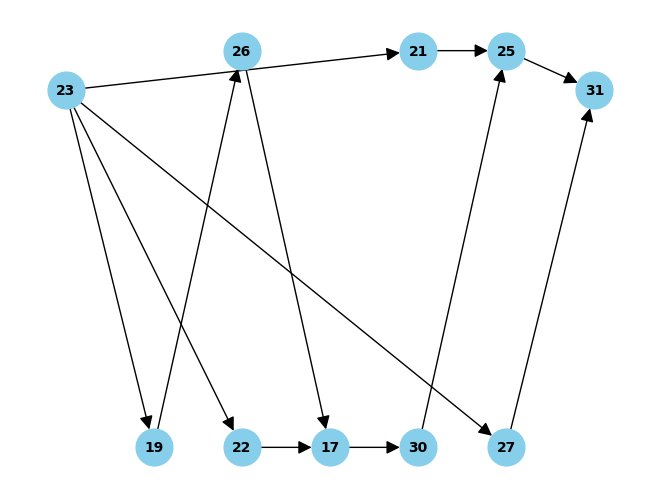

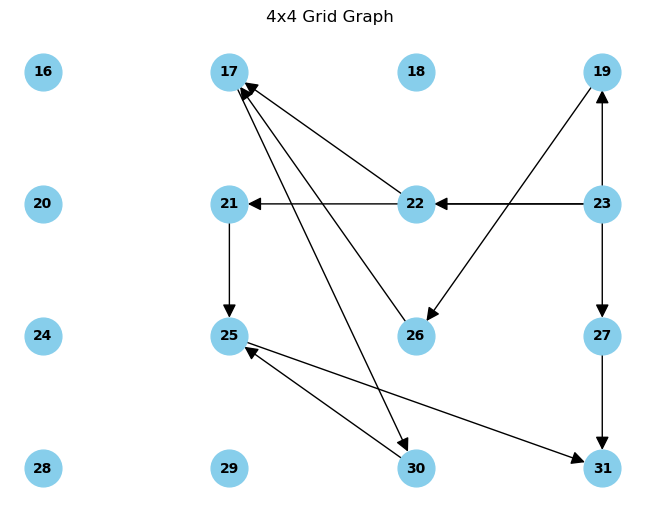

In [13]:
index = 6
displayGraph(index,task=True)
displayGraph(index)
graph = filtered_parameter_df.loc[index, 'map_graph']
visGraphGrid(graph.edges)